# CLUSTERING DE SEMILLAS

## Introducción

En esta practica nos enfocamos en clustering. Clustering es una técnica de aprendizaje no supervidado para organizar en distintos grupos los datos de una semilla, de manera que los datos en un grupo tengan características similares.
Primero usaremos una herramienta llamada PCA para determinar cuál es el mejor scaler para usar con esta semilla y luego aplicaremos distintos modos de agrupamiento con el objetivo de encontrar los hiper-parametros más relevantes y discutir los resultados obtenidos.

#### Integrantes: Javier Díez y Mario Hidalgo

area          0
perimetro     0
compacidad    0
longitud      0
anchura       0
asimetria     0
surco         0
clase         0
dtype: int64 0


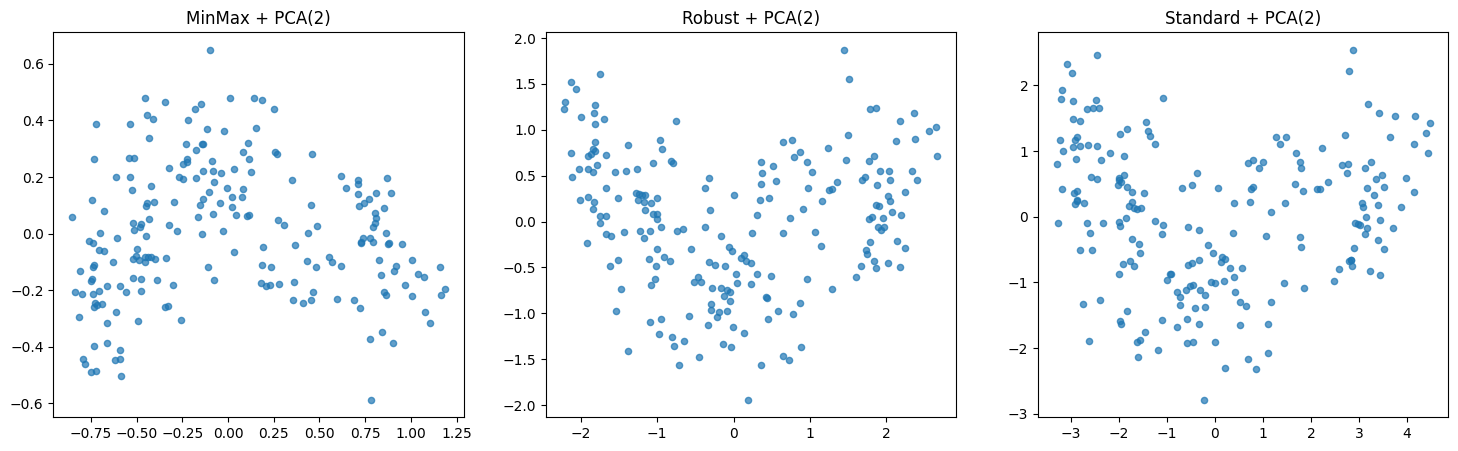

In [2]:
# ─ Imports básicos ─
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─ Semilla de reproducibilidad ─
NIA = 100495801
np.random.seed(NIA)

# ─ scikit-learn pipelines y utilidades ─
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage

# ─ Ajustes de visualización ─
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

# 2. Carga y exploración de datos

# Leer el CSV 
df = pd.read_csv('semillas.csv')  
df.head(), df.describe()

# Comprobar nulos, duplicados…
print(df.isna().sum(), df.duplicated().sum())

# 3. Comparación de scalers con PCA (0.25 p)

scalers = {
    'MinMax': MinMaxScaler(),
    'Robust': RobustScaler(),
    'Standard': StandardScaler()
}

fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, (name, scaler) in zip(axes, scalers.items()):
    pipe = make_pipeline(scaler, PCA(n_components=2, random_state=NIA))
    X2 = pipe.fit_transform(df.drop('clase', axis=1))
    ax.scatter(X2[:,0], X2[:,1], s=20, alpha=0.7)
    ax.set_title(f'{name} + PCA(2)')
plt.show()


## Evaluación de scalers
De los diferentes scalers, podemos observar que "MinMax" es el que nos da unos parámetros menos amplios ([-0.75, 0.75], [-0.6, 0.6]) y es por tanto el primero que vamos a descartar. En cuanto a los otros dos si bien el "Standard scaler" nos da una mayor amplitu de ejes, existen algunos valores apartados que provocan este estiramiento del eje mientras que en el Robust scaler vemos un poco más de condensación y por tanto será el que elijamos.

## Aplicación de técnicas de clustering

### Tipos de clustering
Los tipos de clustering que vamos a realizar son los siguientes:

- **Basados en centroides**: Asumen que los datos cercanos pertenecen al mismo cluster. Técnica a usar: K-Means.
- **Basados en conectividad**: Forman agrupamientos anidados. Técnicas a usar: dendrogramas y clustering jerárquico.
- **Basados en densidad**: Los clusters son regiones densas de puntos conectados. Técnica a usar: DBSCAN.

### K-Means clustering
Primero aplicamos K-Means sobre los datos proyectados a 2D. Para determinar el número óptimo de clusters, usamos el método del codo y la puntuación de silueta.
El método del codo consiste en calcular la inercia, que es la suma de distancias cuadradas de los puntos a sus centroides, para diferentes valores de k. El objetivo es encontrar el punto donde la reducción de la inercia deja de ser significativa.
Para ello empleamos el uso de la silueta, que es un medidor de cada punto para saber si se encuentra mejor en el cluster en el que está o en otro.

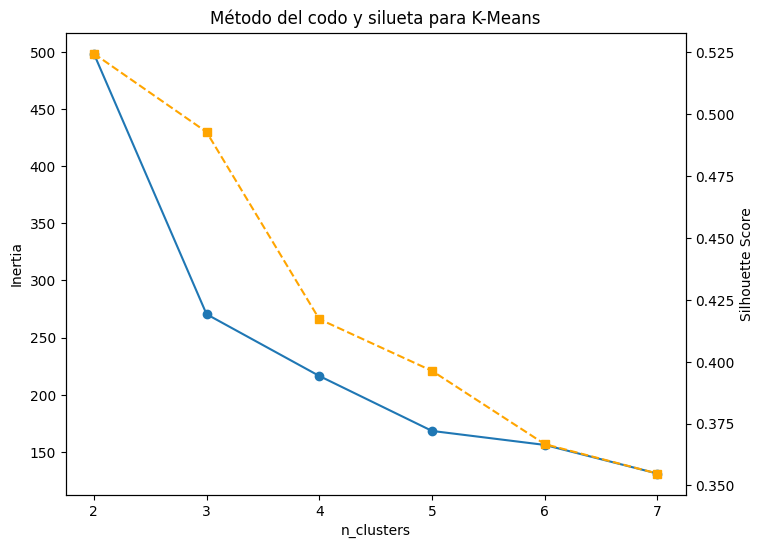

In [13]:
# Método del codo y silueta para K-Means
inertias = []
silhouettes = []
K_range = range(2, 8)
# Buscamos el número óptimo de clusters para K-Means, entre 2 y 7
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=NIA)
    labels = kmeans.fit_predict(X2)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X2, labels))

fig, ax1 = plt.subplots()
ax1.plot(K_range, inertias, 'o-', label='Inertia (Codo)')
ax1.set_xlabel('n_clusters')
ax1.set_ylabel('Inertia')
ax2 = ax1.twinx()
ax2.plot(K_range, silhouettes, 's--', color='orange', label='Silhouette')
ax2.set_ylabel('Silhouette Score')
plt.title('Método del codo y silueta para K-Means')
plt.show()

Al observar el gráfico comprobamos que el mejor número de clusters es 3 ya que es el numero que tiene la mayor diferencia entre las lineas de siluetas (naranja) con respecto de la inercia (azul). En k=3, la silueta está en un punto muy alto, además de que la inercia se encuentra mucho más por debajo que en k=2. Esto indica que la separación entre clusteres es buena (la silueta es alta) y la separación entre clusteres no afecta tanto (la pendiente a partir de k=3 de la línea de inercia da un cambio drástico).
Ahora visualizamos los clusters resultantes con k=3.

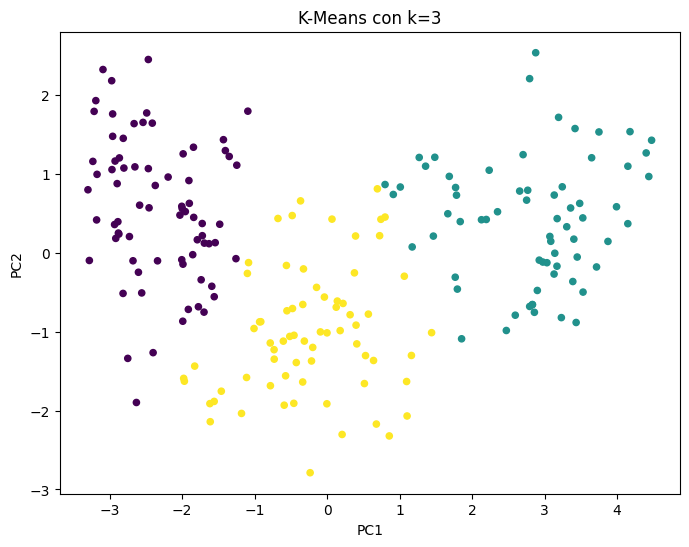

In [17]:
# Aplicar K-Means
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=NIA)
labels_kmeans = kmeans.fit_predict(X2)
plt.scatter(X2[:,0], X2[:,1], c=labels_kmeans, cmap='viridis', s=20)
plt.title(f'K-Means con k={k_opt}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Clustering jerárquico
Probamos diferentes métodos de linkage ('ward', 'complete', 'average') y visualizamos el dendrograma para cada uno para decidir el número de clusters. Después, mostramos la agrupación resultante para cada método.

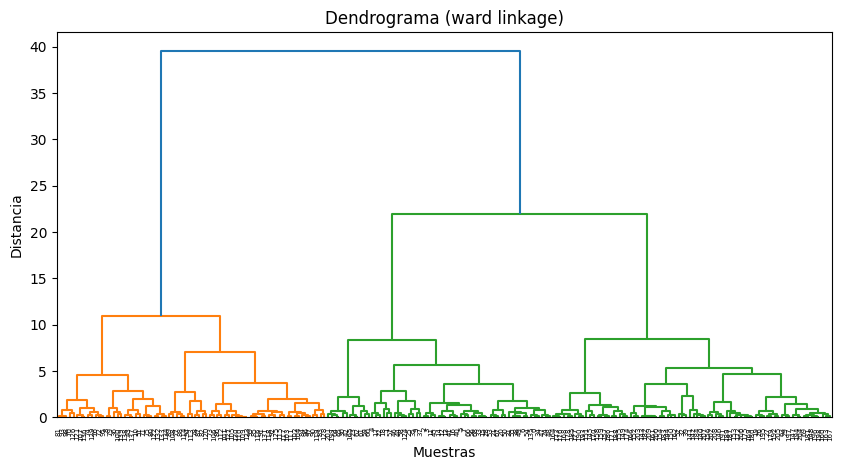

In [ ]:
# Dendrograma con linkage 'ward'
Z_ward = linkage(X2, method='ward')
plt.figure(figsize=(10,5))
dendrogram(Z_ward)
plt.title('Dendrograma (ward)')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

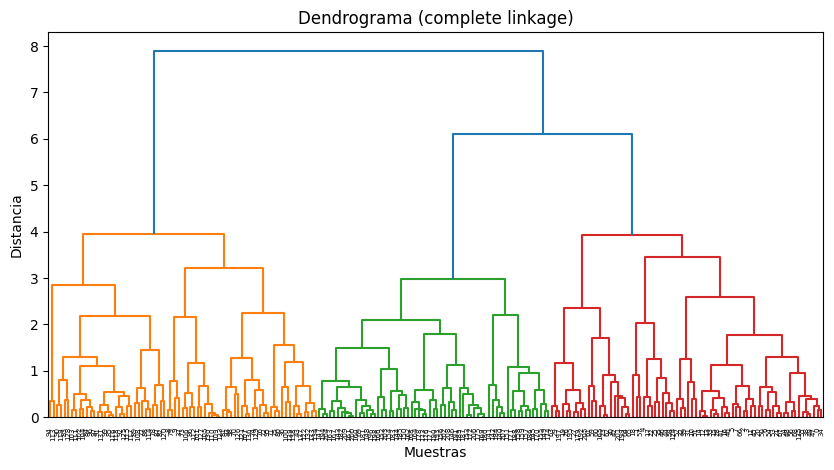

In [ ]:
# Dendrograma con linkage 'complete'
Z_complete = linkage(X2, method='complete')
plt.figure(figsize=(10,5))
dendrogram(Z_complete)
plt.title('Dendrograma (complete)')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

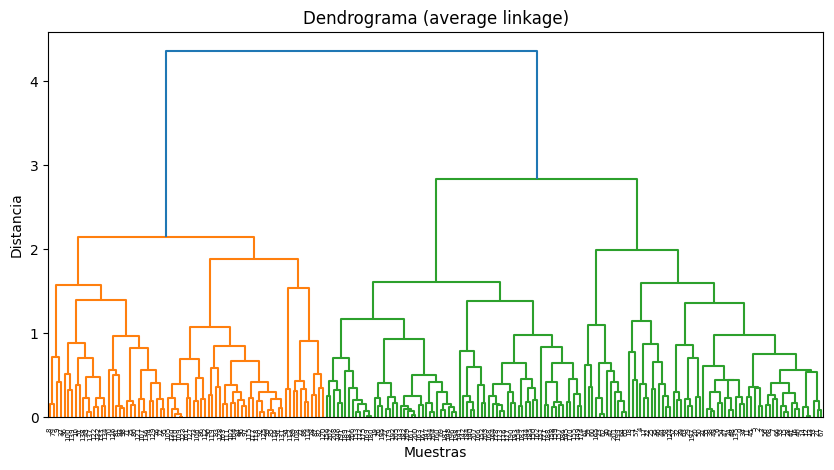

In [ ]:
# Dendrograma con linkage 'average'
Z_average = linkage(X2, method='average')
plt.figure(figsize=(10,5))
dendrogram(Z_average)
plt.title('Dendrograma (average)')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

Para los métodos 'ward' y 'average' usaremos 3 clústeres porque, según los dendrogramas, parece ser la mejor división de los atributos. Por otro lado, para 'complete' usaremos 4.
Ahora empleamos dicho número de clusteres para cada método de linkage.

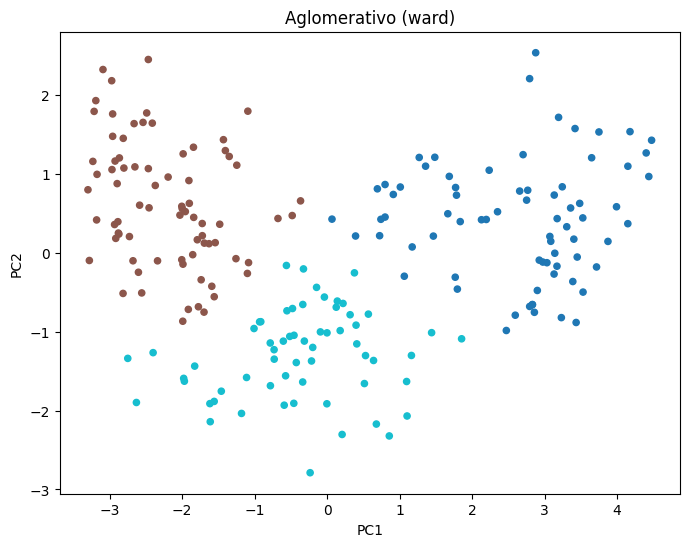

In [33]:
# Visualización de clusters para linkage 'ward'
model_ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_ward = model_ward.fit_predict(X2)
plt.scatter(X2[:,0], X2[:,1], c=labels_ward, cmap='tab10', s=20)
plt.title('Aglomerativo (ward)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

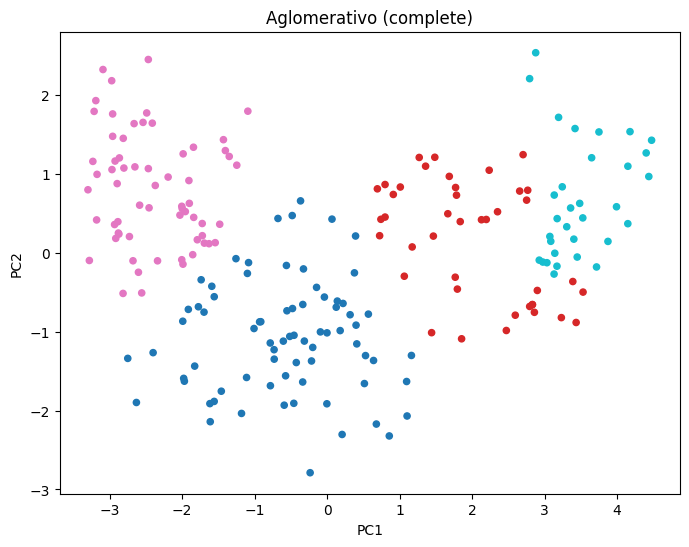

In [38]:
# Visualización de clusters para linkage 'complete'
model_complete = AgglomerativeClustering(n_clusters=4, linkage='complete')
labels_complete = model_complete.fit_predict(X2)
plt.scatter(X2[:,0], X2[:,1], c=labels_complete, cmap='tab10', s=20)
plt.title('Aglomerativo (complete)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

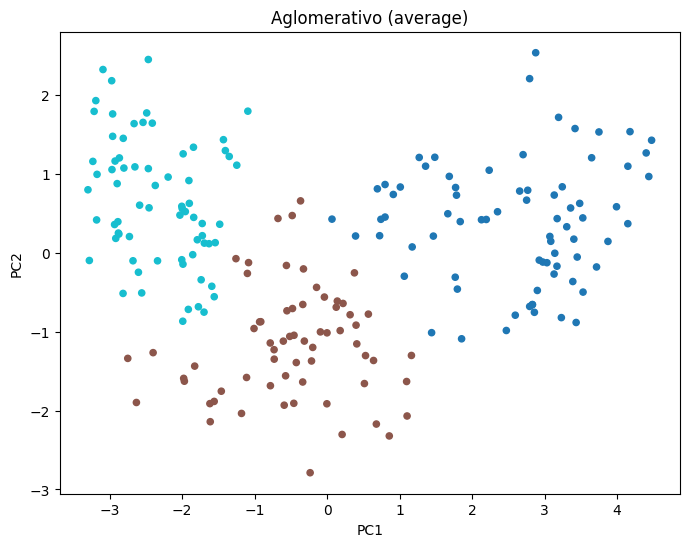

In [42]:
# Visualización de clusters para linkage 'average'
model_average = AgglomerativeClustering(n_clusters=3, linkage='average')
labels_average = model_average.fit_predict(X2)
plt.scatter(X2[:,0], X2[:,1], c=labels_average, cmap='tab10', s=20)
plt.title('Aglomerativo (average)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### DBSCAN
Probamos diferentes valores de eps y min_samples para encontrar la mejor separación de clusters. Por lo general, el min_samples viene dado con 2 * número de dimensiones. Como estamos en 2 dimensiones, min_samples = 4.
Para calcular eps calculamos la distancia al k-ésimo vecino más cercano para cada punto (donde k = min_samples) y se ordenan estas distancias. Elegimos el eps cuya pendiente se cambie más bruscamente.

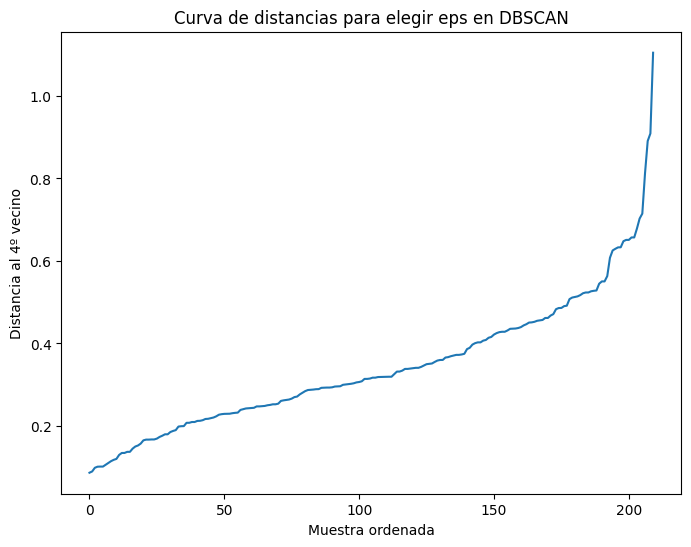

In [ ]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 2*2 # 2*dimensiones (2D)
neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(X2)
distances, indices = neighbors_fit.kneighbors(X2)
distances = np.sort(distances[:,n_neighbors-1])
plt.plot(distances)
plt.title('Curva de distancias para elegir eps en DBSCAN')
plt.xlabel('Muestra ordenada')
plt.ylabel('Distancia al {n_neighbors}º vecino')
plt.show()

Aproximadamente el eps cuya pendiente cambia más rápidamente es 0.55. Por eso usaremos DBSCAN con dicho valor.

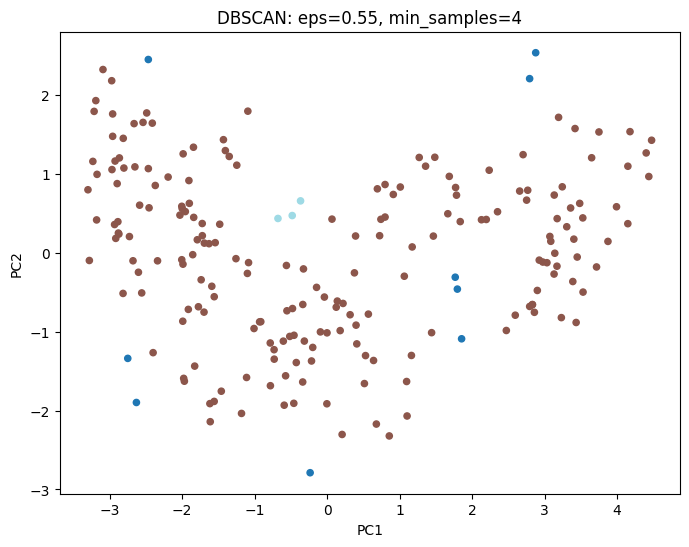

In [54]:
# Aplicar DBSCAN con parámetros elegidos (por ejemplo, eps=0.3, min_samples=5)
eps = 0.55
min_samples = 4
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(X2)
plt.scatter(X2[:,0], X2[:,1], c=labels_dbscan, cmap='tab20', s=20)
plt.title(f"DBSCAN: eps={eps}, min_samples={min_samples}")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

En general, el ajuste de hiperparámetros es el siguiente:

**K_Means:**

Clusters = 3


**Clustering jerárquico:**

1. Ward: Clusters = 3

2. Complete: Clusters = 4
    
3. Average: Clusters = 3


**DBSCAN:**

min vecinos = 4

eps = 0.55

## Análisis de los datos